## Lecture 5

In this demonstration, we will explore some components of market basket analysis. Using datasets about consumer transactions, we will determine frequent items to generate association rules between items. In a business setting, we could use the association rules for marketing tasks like cross-selling, sales promotions, catalogue design, or discount programs.

In [1]:
# importing packages 

import pandas as pd
import numpy as np

import graphviz

import pyspark
import pyspark.ml

# changing some settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

# indicating paths to files

import os
from IPython.display import Image

home = os.environ['HOME']
path_data = f"{home}/shared/lecture-5/transactions.txt"
path_data_parquet = f"{home}/shared/lecture-5/transactions.parquet"
path_images = f"{home}/shared/lecture-5/images/"

We will look at three approaches to market basket analysis

- Apriori
- Eclat 
- FPGrowth

Each approach will allow us to determine frequent patterns and association rules. We will work with two datasets containing records of consumer transactions.

### Example 1 

The Apriori approach to market basket analysis involves two steps

- join 
   * generate candidate itemsets from combinations of frequent itemsets
- prune
   * remove infrequent candidate itemsets to determine frequent itemsets 

We have the transactions stored in `transactions_example.txt`.

In [2]:
!cat transactions_example.txt

I1 I2 I5 T1
I2 I4 T2
I2 I3 T3
I1 I2 I4 T4
I1 I3 T5
I2 I3 T6
I1 I3 T7
I1 I2 I3 I5 T8
I1 I2 I3 T9

Note that the `cat` command for the command line interface allows us to view the contents of the file.

In [3]:
with open("transactions_example.txt") as file_handle:
    lines = file_handle.readlines()

We can read the lines into `lines` variable.

In [4]:
transactions = [line.split(" ")[0:-1] for line in lines]
transactions

[['I1', 'I2', 'I5'],
 ['I2', 'I4'],
 ['I2', 'I3'],
 ['I1', 'I2', 'I4'],
 ['I1', 'I3'],
 ['I2', 'I3'],
 ['I1', 'I3'],
 ['I1', 'I2', 'I3', 'I5'],
 ['I1', 'I2', 'I3']]

We remove the identifiers for the transactions `T1`,...,`T9`.

In [5]:
number_of_transactions = len(transactions)
number_of_transactions

9

We learn that we have 9 transactions.

In [6]:
items = []

for transaction in transactions:
    items = items + transaction

items = np.unique(items)
items

array(['I1', 'I2', 'I3', 'I4', 'I5'], dtype='<U2')

Each of the transactions contains items from an inventory of 5 products `I1`,...,`I5`.

In [7]:
minimum_absolute_support = 2

minimum_support = minimum_absolute_support / number_of_transactions 
minimum_support

0.2222222222222222

We will set the minimum absolute support to 2 transactions. So a frequent itemset must appear in at least 22\% of transactions.

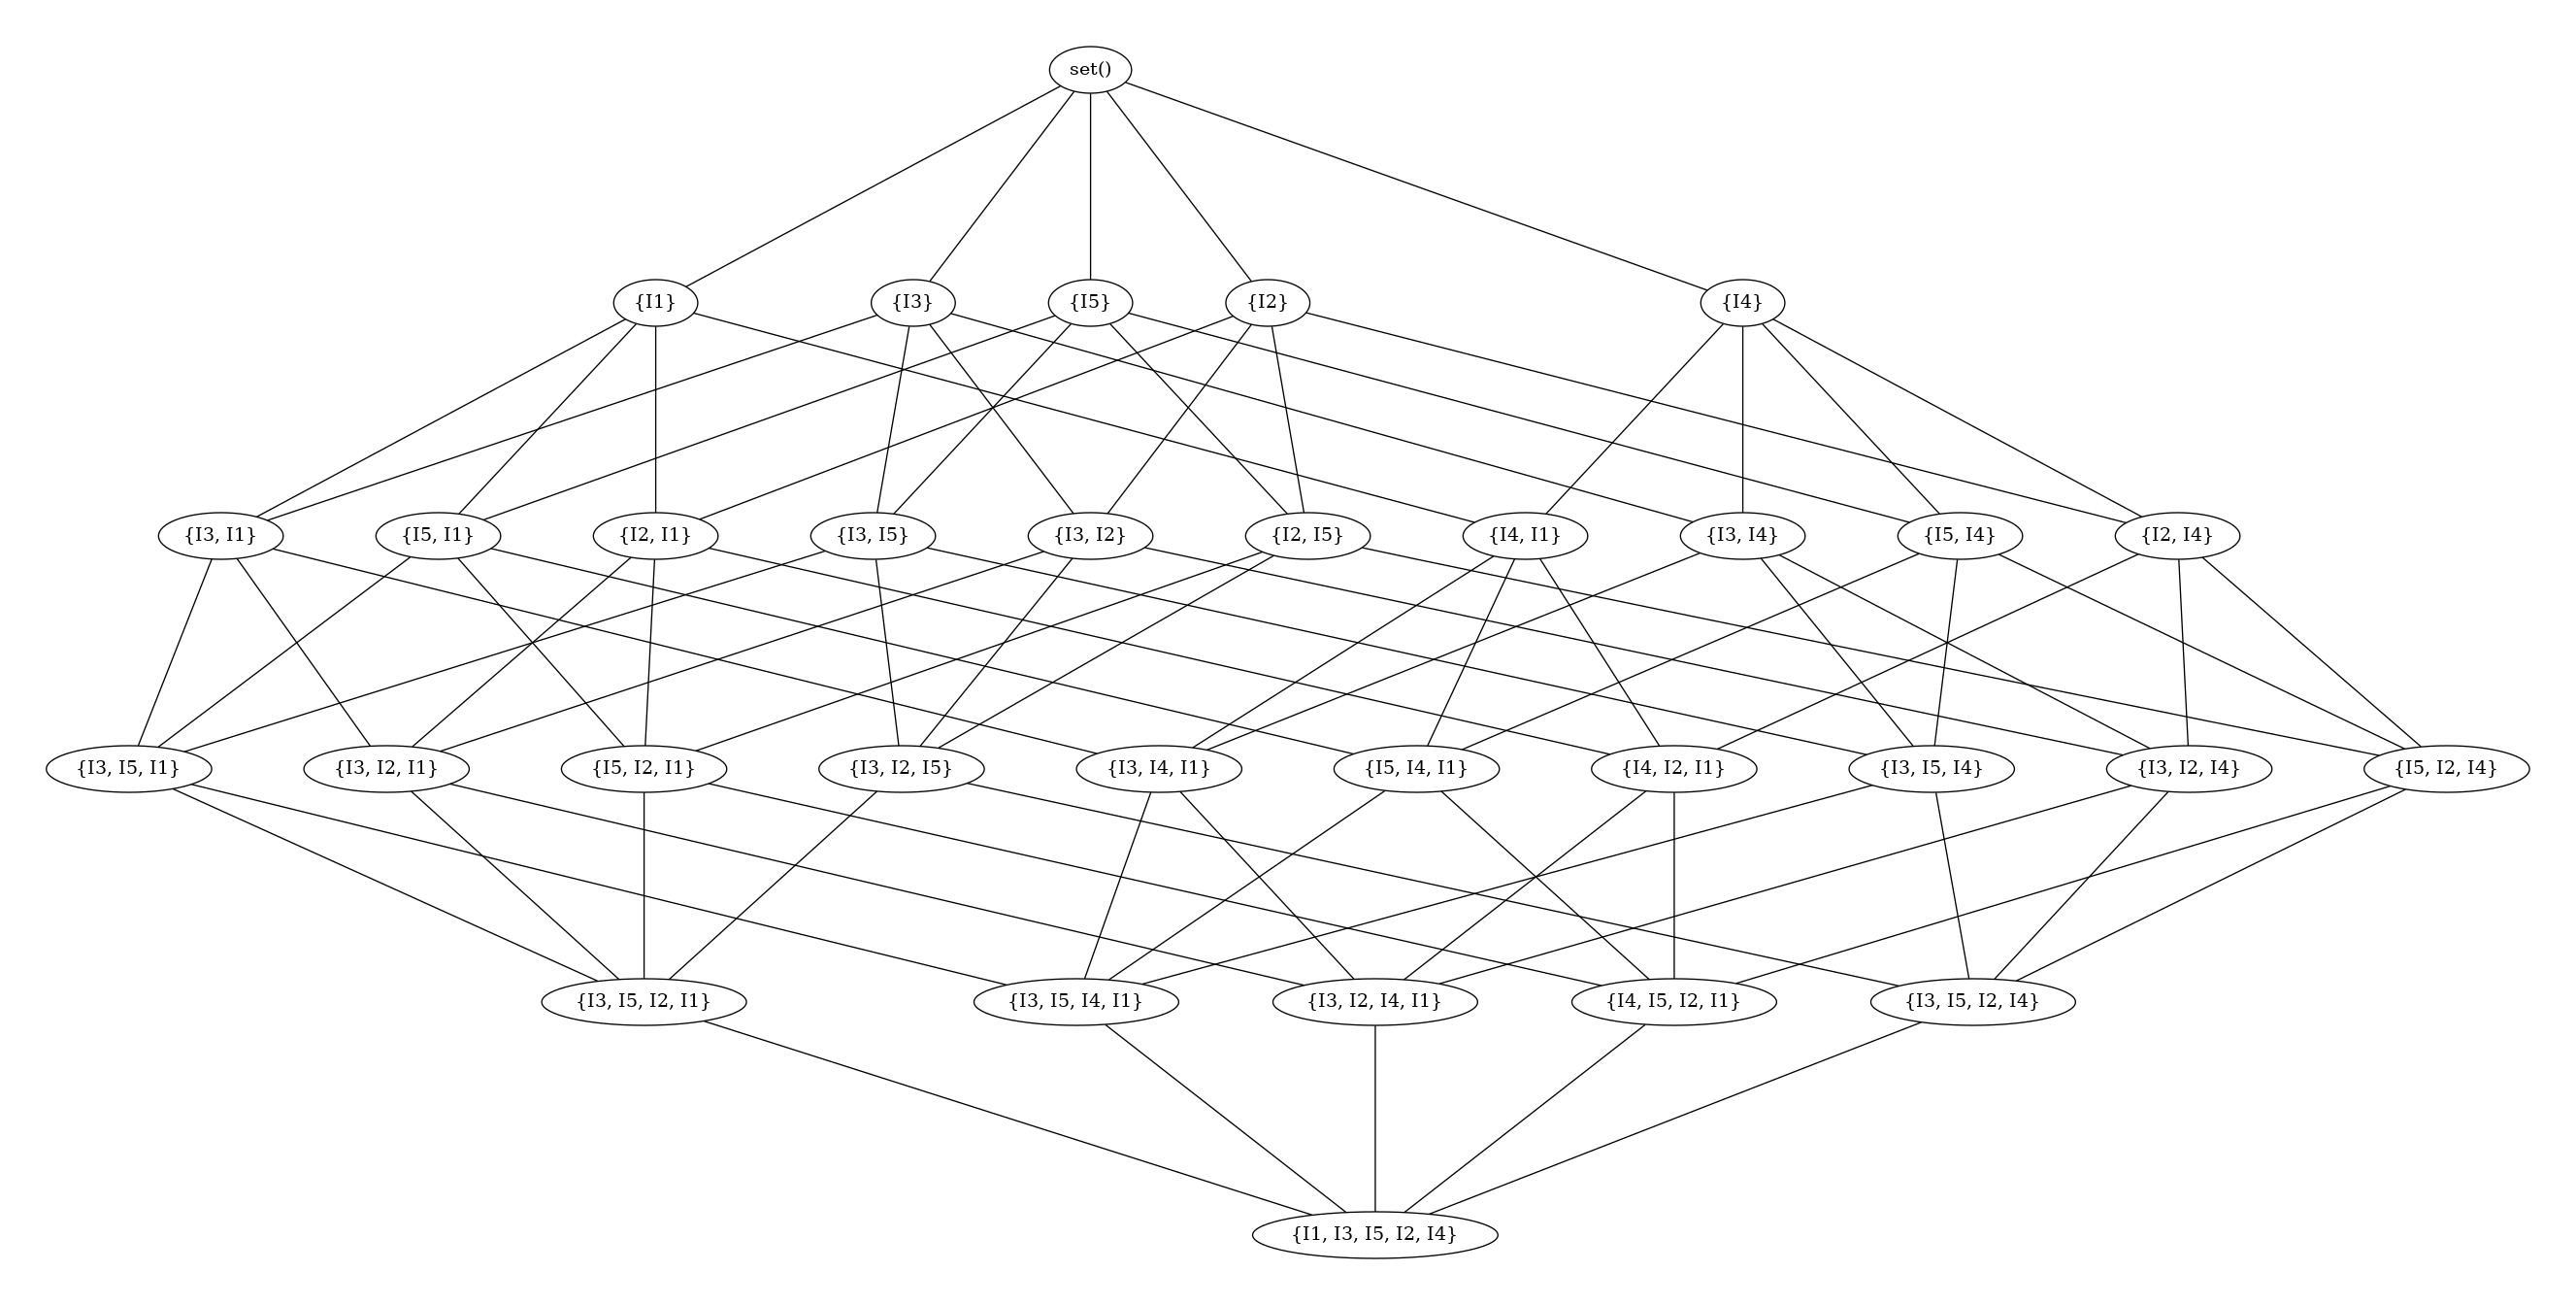

In [8]:
Image(path_images+"all_itemsets.png")

#### Frequent 1-Itemsets

We can determine the frequent 1-itemsets by scanning the transactions

In [9]:
counts_candidates_1 = dict().fromkeys(items, 0)

for transaction in transactions:
    for item in transaction:
        counts_candidates_1[item] += 1 
        
counts_candidates_1

{'I1': 6, 'I2': 7, 'I3': 6, 'I4': 2, 'I5': 2}

Note that we had 9 iterations because we have 9 transactions. For each iteration, we look through the different items in the transaction. 

Scanning the records involves 23 operations.

In [10]:
itemset_1 = []

for key, value in counts_candidates_1.items():
    if value >= minimum_absolute_support:
        itemset_1.append(key)

itemset_1

['I1', 'I2', 'I3', 'I4', 'I5']

We learn that all of the items appear in at least 2 transactions. So we did not need to prune any candidates.

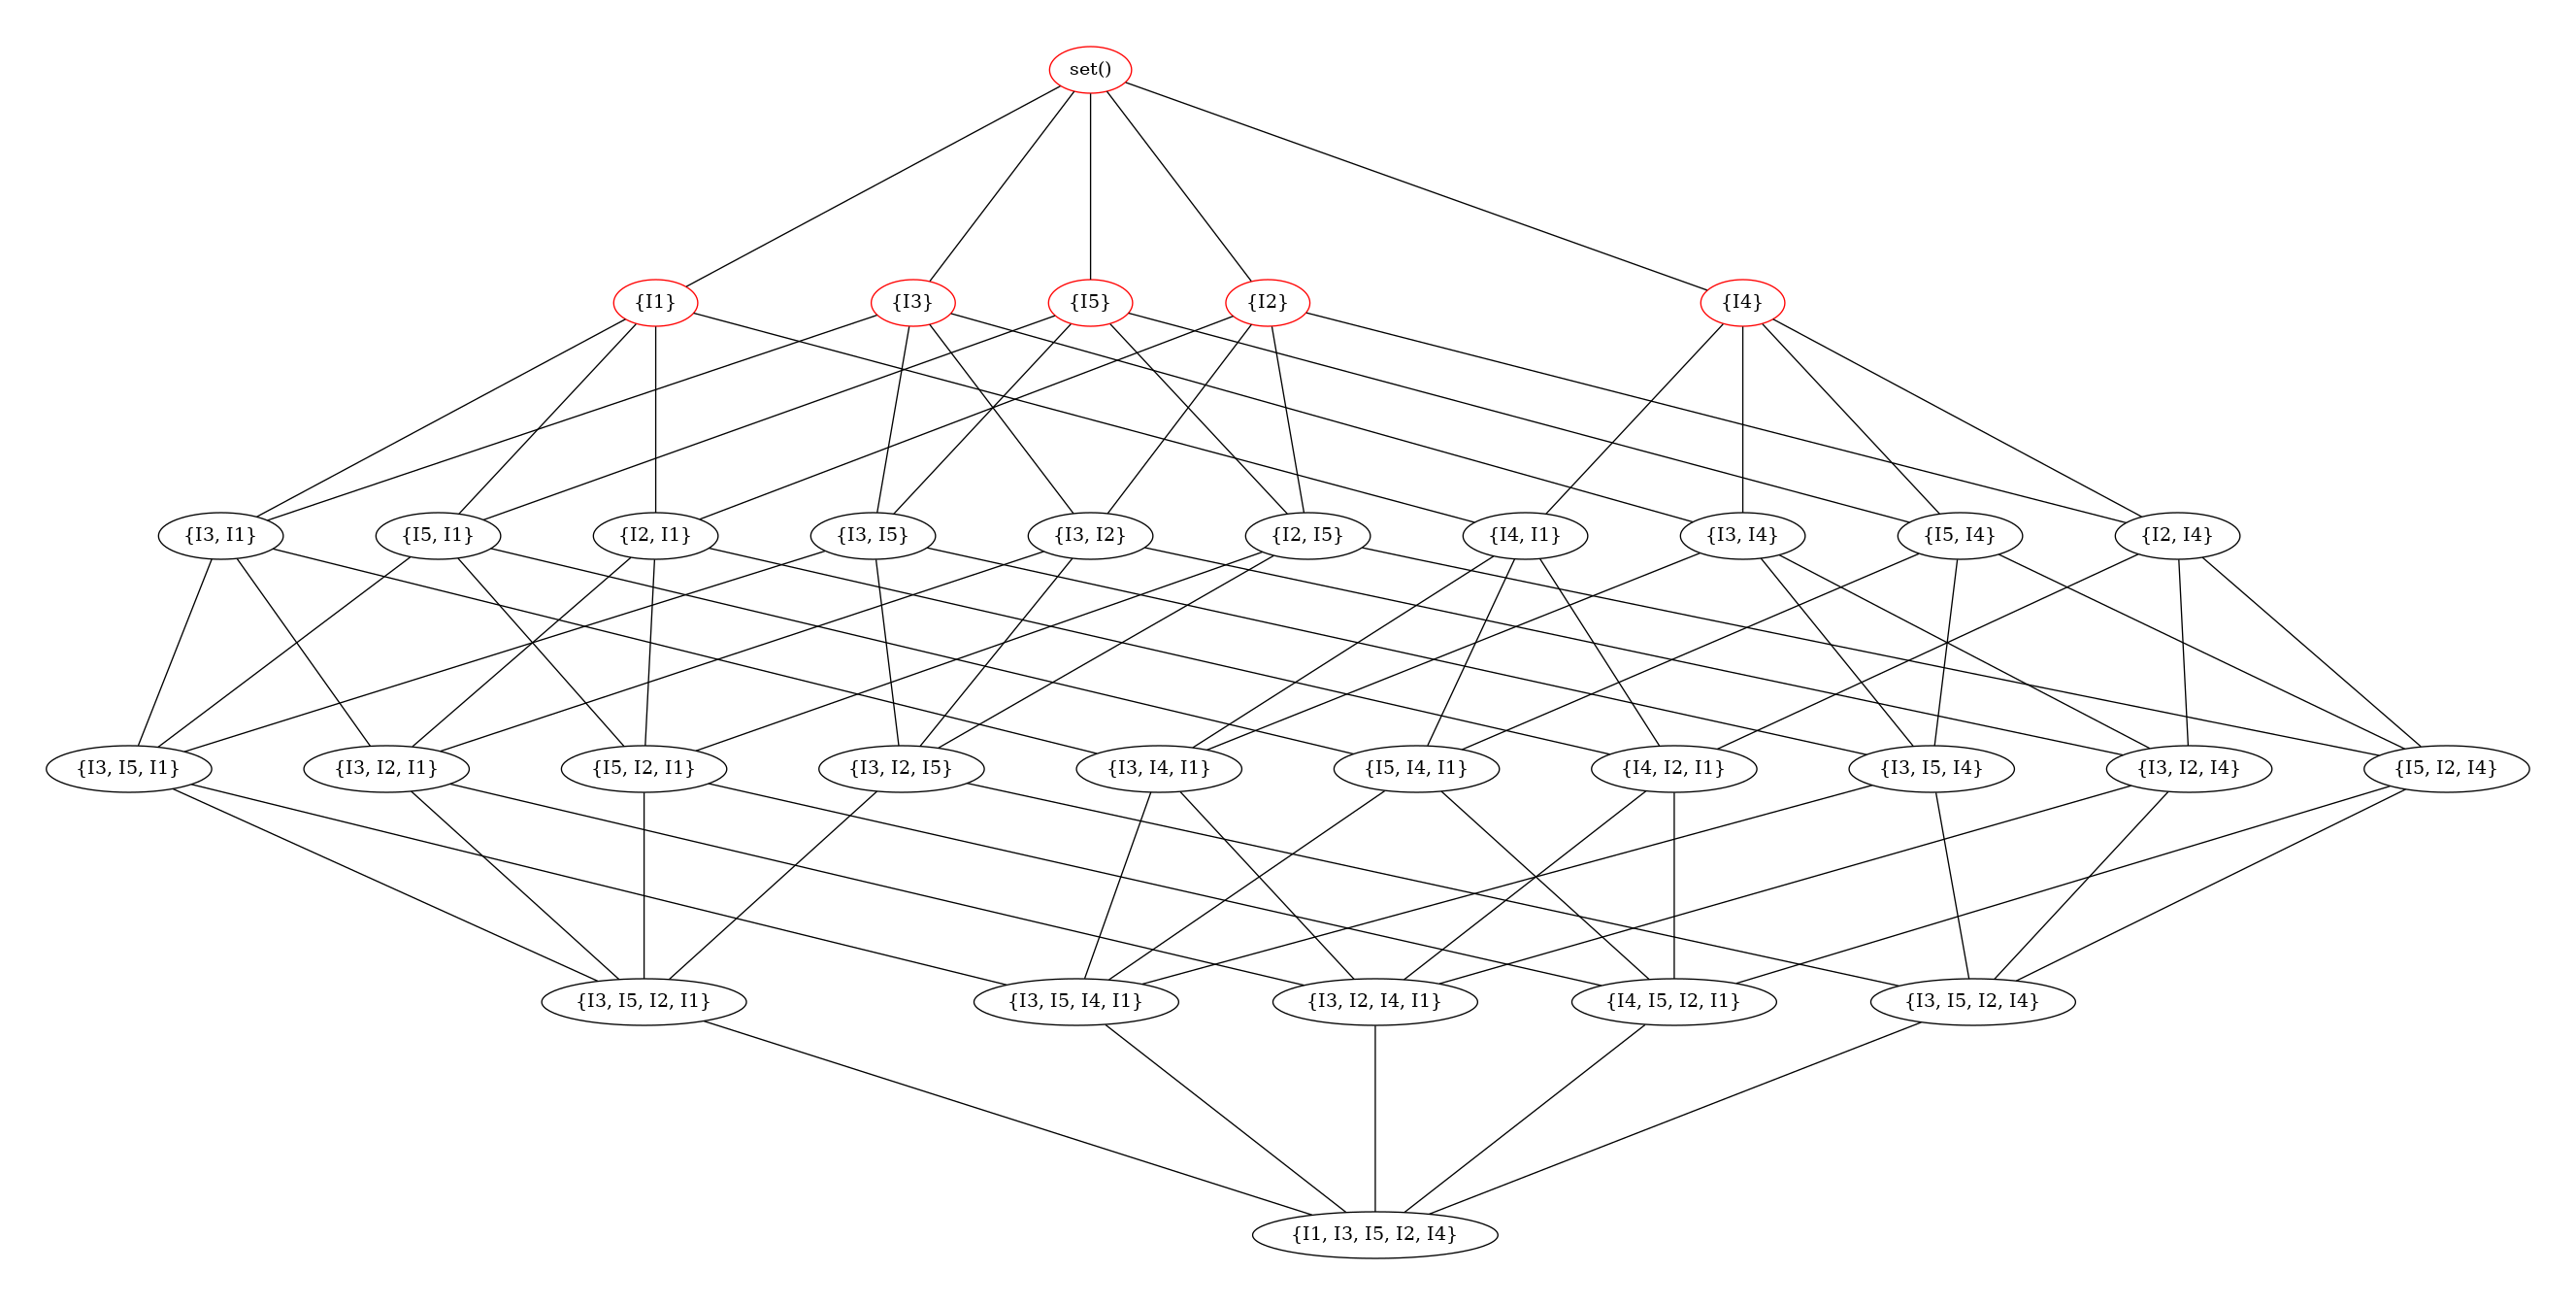

In [11]:
Image(path_images+"itemsets_1.png")

#### Frequent 2-Itemsets

We need to determine the candidate 2-itemsets from combinations of the frequent 1-itemsets.

In [12]:
combinations_itemset_1 = []

for item_1 in itemset_1:
    for item_2 in itemset_1:
        if item_1 < item_2:
            combinations_itemset_1.append((item_1, item_2))

combinations_itemset_1

[('I1', 'I2'),
 ('I1', 'I3'),
 ('I1', 'I4'),
 ('I1', 'I5'),
 ('I2', 'I3'),
 ('I2', 'I4'),
 ('I2', 'I5'),
 ('I3', 'I4'),
 ('I3', 'I5'),
 ('I4', 'I5')]

We can avoid duplicate pairs by sorting the labels for the items. 

In [57]:
itemset_1[0] < itemset_1[1]

True

Here `I1` is less than `I2`

- the first characters are equal 
- the second characters have order `1 < 2` 

We call this lexicographic ordering. It reminds us of the order of words in an English dictionary. 

In [13]:
counts_candidates_2 = dict().fromkeys(combinations_itemset_1, 0)

for transaction in transactions:
    for pair in combinations_itemset_1:
        if set(pair).issubset(set(transaction)):
            counts_candidates_2[pair] += 1 
            
counts_candidates_2

{('I1', 'I2'): 4,
 ('I1', 'I3'): 4,
 ('I1', 'I4'): 1,
 ('I1', 'I5'): 2,
 ('I2', 'I3'): 4,
 ('I2', 'I4'): 2,
 ('I2', 'I5'): 2,
 ('I3', 'I4'): 0,
 ('I3', 'I5'): 1,
 ('I4', 'I5'): 0}

Note that we had 9 iterations because we have 9 transactions. For each iteration, we look for each of the 10 candidate 1-itemsets.

Scanning the records involves 90 operations.

In [14]:
itemset_2 = []

for key, value in counts_candidates_2.items():
    if value >= minimum_absolute_support:
        itemset_2.append(key)

itemset_2

[('I1', 'I2'),
 ('I1', 'I3'),
 ('I1', 'I5'),
 ('I2', 'I3'),
 ('I2', 'I4'),
 ('I2', 'I5')]

We filter the infrequent itemsets from the candidate 2-itemsets.

In [69]:
len(counts_candidates_2) - len(itemset_2)

4

We learn that 4 of the candidate 2-itemsets appear in fewer than 2 transactions. So we need to prune these candidates.

In [ ]:
Image(path_images+"itemsets_2.png")

#### Frequent 3-Itemsets

We need to determine the candidate 3-itemsets from combinations of the frequent 2-itemsets. Remember that we have sorted the items within the itemsets. We will join on the first and second items. So we would join 

$$\{\text{Item X}, \text{Item Y}\}$$

and 

$$\{\text{Item W}, \text{Item Z} \}$$

when $X = W$ and $Y < Z$. We would obtain

$$\{\text{Item X}, \text{Item Y}, \text{Item Z} \}$$


In [15]:
combinations_itemset_2 = []

for item_1 in itemset_2:
    for item_2 in itemset_2:
        if (item_1[0] == item_2[0]) and (item_1[1] < item_2[1]):
            combinations_itemset_2.append((item_1[0], item_1[1], item_2[1]))

combinations_itemset_2

[('I1', 'I2', 'I3'),
 ('I1', 'I2', 'I5'),
 ('I1', 'I3', 'I5'),
 ('I2', 'I3', 'I4'),
 ('I2', 'I3', 'I5'),
 ('I2', 'I4', 'I5')]

Before we count the number of occurrences of the candidate 3-itemsets, we need to prune any candidate 3-itemset containing an infrequent 2-itemset.

In [16]:
for combination in combinations_itemset_2:
    condition_1 = (combination[0], combination[1]) in itemset_2
    condition_2 = (combination[0], combination[2]) in itemset_2
    condition_3 = (combination[1], combination[2]) in itemset_2
    
    if not (condition_1 and condition_2 and condition_3):
        combinations_itemset_2.remove(combination)
        
combinations_itemset_2

[('I1', 'I2', 'I3'),
 ('I1', 'I2', 'I5'),
 ('I2', 'I3', 'I4'),
 ('I2', 'I4', 'I5')]

We removed 2 candidate 3-itemsets. 

Now we can count the number of occurences

In [19]:
counts_candidates_3 = dict().fromkeys(combinations_itemset_2, 0)

for transaction in transactions:
    for triple in combinations_itemset_2:
        if set(triple).issubset(set(transaction)):
            counts_candidates_3[triple] += 1 
            
counts_candidates_3

{('I1', 'I2', 'I3'): 2,
 ('I1', 'I2', 'I5'): 2,
 ('I2', 'I3', 'I4'): 0,
 ('I2', 'I4', 'I5'): 0}

Note that we had 9 iterations because we have 9 transactions. For each iteration, we look for each of the 5 candidate 1-itemsets.

Scanning the records involves 45 operations.

In [20]:
itemset_3 = []

for key, value in counts_candidates_3.items():
    if value >= minimum_absolute_support:
        itemset_3.append(key)

itemset_3

[('I1', 'I2', 'I3'), ('I1', 'I2', 'I5')]

We filter the infrequent itemsets from the candidate 2-itemsets.

In [21]:
len(counts_candidates_3) - len(itemset_3)

2

We learn that 2 of the candidate 3-itemsets appear in fewer than 2 transactions. So we need to prune these candidates.

In [ ]:
Image(path_images+"itemsets_3.png")

#### Order of Search

The Apriori approach is a breadth-first search. Here the phrase breadth-first search means that we need to study all of the frequent $k$-itemsets before we can study the frequent $k+1$-itemsets.

In [ ]:
Image(path_images+"itemsets_bfs.png")

For each transaction, we stored a basket of items. Instead we could change the approach to storing the records. 

In [180]:
item_counts = dict().fromkeys(items, [])

for idx, transaction in enumerate(transactions):
    for key, value in item_counts.items():
        if key in transaction:
            item_counts[key] = value + [idx + 1] 

item_counts

{'I1': [1, 4, 5, 7, 8, 9],
 'I2': [1, 2, 3, 4, 6, 8, 9],
 'I3': [3, 5, 6, 7, 8, 9],
 'I4': [2, 4],
 'I5': [1, 8]}

For each item, we could store a list of transactions. Now we can directly compare the occurences of items. 

In [181]:
transaction_item2_item5 = set(item_counts["I2"]).intersection(set(item_counts["I5"]))

transaction_item2_item5_item1 = transaction_item2_item5.intersection(set(item_counts["I1"]))

transaction_item2_item5_item1

{1, 8}

For example, we can determine that transaction 1 and transaction 8 both include `I1`, `I2` and `I5`. We did not need to study other frequent itemsets. We use the phrase depth-first search.

In [ ]:
Image(path_images+"itemsets_dfs.png")

### Example 2

The Eclat approach to market basket analysis switches the roles of transactions and items. We need to rearrange the data to store transactions for each item rather than items for each transaction. After we rearrange the data, we have two steps 

- join 
   * generate candidate itemsets from combinations of frequent itemsets
- prune
   * form intersections of sets of transactions

So Apriori and Eclat have the same join step and different prune step.

We have the transactions stored in `shared/` folder.

In [2]:
!head ~/shared/lecture-5/transactions.txt

FRO11987 ELE17451 ELE89019 SNA90258 GRO99222 
GRO99222 GRO12298 FRO12685 ELE91550 SNA11465 ELE26917 ELE52966 FRO90334 SNA30755 ELE17451 FRO84225 SNA80192 
ELE17451 GRO73461 DAI22896 SNA99873 FRO86643 
ELE17451 ELE37798 FRO86643 GRO56989 ELE23393 SNA11465 
ELE17451 SNA69641 FRO86643 FRO78087 SNA11465 GRO39357 ELE28573 ELE11375 DAI54444 
ELE17451 GRO73461 DAI22896 SNA99873 FRO18919 DAI50921 SNA80192 GRO75578 
ELE17451 ELE59935 FRO18919 ELE23393 SNA80192 SNA85662 SNA91554 DAI22177 
ELE17451 SNA69641 FRO18919 SNA90258 ELE28573 ELE11375 DAI14125 FRO78087 
ELE17451 GRO73461 DAI22896 SNA80192 SNA85662 SNA90258 DAI46755 FRO81176 ELE66810 DAI49199 DAI91535 GRO94758 ELE94711 DAI22177 
ELE17451 SNA69641 DAI91535 GRO94758 GRO99222 FRO76833 FRO81176 SNA80192 DAI54690 ELE37798 GRO56989 


Note that the `head` command for the command line interface allows us to view the first 5 lines of a file.

In [25]:
with open(path_data) as file_handle:
    lines = file_handle.readlines()

We can read the lines into `lines` variable.

In [26]:
transactions = [line.split(" ")[0:-1] for line in lines]
transactions[0]

['FRO11987', 'ELE17451', 'ELE89019', 'SNA90258', 'GRO99222']

We have a larger dataset than Example 1.

In [27]:
number_of_transactions = len(transactions)
number_of_transactions

31101

We learn that we have 31101 transactions.

In [28]:
transactions_combined = []

for transaction in transactions:
    transactions_combined += transaction

We can combine the items across transactions to determine the size of the inventory.

In [29]:
items = np.unique(transactions_combined)

len(items)

12592

Each of the transactions contains items from an inventory of 12592 products.

In [8]:
minimum_absolute_support = 100

minimum_support = minimum_absolute_support / number_of_transactions 
minimum_support

0.003215330696762162

We will set the minimum absolute support to 100 transactions. So a frequent itemset must appear in at least 0.3\% of transactions.

#### Row Oriented Format

We can store the records in a table. The table has 

- rows consisting of transactions
- columns consisting of distinct items 

We have entry 1 to indicate the inclusion of an item in the transaction. Otherwise we have 0.

In [18]:
table = pd.read_parquet(path_data_parquet)

table

,DAI11153,DAI11223,DAI11238,DAI11257,...,DAI46827,DAI46863,DAI46921,DAI46953
0,0,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,0,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,0,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,...,0,0,0,0
996,0,0,0,0,...,0,0,0,0
997,0,0,0,0,...,0,0,0,0
998,0,0,0,0,...,0,0,0,0


Note that the table take 8MB of space in memory.

In [19]:
table.memory_usage().sum()

8000128

However, we have just stored 1000 rows and 1000 columns. If we included all transactions and all products, then the table would take 3GB of space in memory. 


Note that the table contains the value 0 for many entries. We can rearrange the data to reduce the size of the table through exlusion of the value 0.

#### Column Oriented Format

We can store the records in a dictionary. The dictionary has 

- keys consisting of items
- values consisting of sets of transactions 

We record all of the transactions containing an item.

In [40]:
table_column_format = dict().fromkeys(items, set())

for idx, transaction in enumerate(transactions):
    for item in transaction:
        table_column_format[item] = table_column_format[item].union({idx})

table_column_format["DAI11153"]

{13917, 14585, 17989, 18020, 18108, 18249, 21404, 21444}

#### Frequent 1-Itemsets

We will use the `pandas` package to process the dataset because we have more transactions and items.

In [42]:
candidate_1 = pd.Series(table_column_format)

We can filter the candidate 1-itemsets through comparison with the minimum absolute support.

In [43]:
itemset_1 = candidate_1[candidate_1.map(lambda x : len(x)) >= minimum_absolute_support]

itemset_1 = itemset_1.to_frame()
itemset_1.columns = ["transactions"]
itemset_1 = itemset_1.sort_index()

itemset_1

,transactions
DAI11223,"{4105, 4106, 27658, 5135, 3607, 4124, 3624, 36..."
DAI11778,"{19714, 16131, 5124, 3846, 3847, 776, 3850, 16..."
DAI13194,"{8965, 6406, 8966, 6408, 8969, 10757, 12809, 2..."
DAI13266,"{28676, 9221, 18952, 521, 18953, 9739, 9230, 5..."
DAI13788,"{24577, 15875, 7684, 13830, 5128, 8200, 26122,..."
...,...
SNA96466,"{22528, 19461, 24581, 24582, 24583, 24584, 245..."
SNA97370,"{28417, 5378, 30469, 17415, 17419, 19467, 1972..."
SNA97586,"{17920, 6658, 5124, 8709, 10760, 5642, 11274, ..."
SNA99654,"{9219, 22022, 25608, 22538, 20492, 27663, 4113..."


We have 647 frequent 1-itemsets.

#### Frequent 2-Itemsets

We can generate candidate 2-itemsets from combinations of frequent 1-itemsets.

In [44]:
candidate_2 = dict()

for item_1, transaction_1 in itemset_1["transactions"].iteritems():
    for item_2, transaction_2 in itemset_1["transactions"].iteritems():
        if item_1 < item_2:
            candidate_2[(item_1, item_2)] = transaction_1.intersection(transaction_2)

candidate_2 = pd.Series(candidate_2)
candidate_2

DAI11223  DAI11778                                                   {}
          DAI13194                                              {10446}
          DAI13266                                              {29868}
          DAI13788                                                   {}
          DAI13902                                       {17475, 25542}
                                            ...                        
SNA97370  SNA99654                                                   {}
          SNA99873    {5568, 13636, 13732, 5225, 5323, 31084, 5326, ...
SNA97586  SNA99654                                                   {}
          SNA99873    {26497, 5316, 26212, 7652, 10760, 23500, 1745,...
SNA99654  SNA99873    {6280, 8072, 7307, 9614, 7962, 2977, 2466, 308...
Length: 208981, dtype: object

We can filter the candidate 2-itemsets through comparison with the minimum absolute support.

In [45]:
itemset_2 = candidate_2[candidate_2.map(lambda x : len(x)) >= minimum_absolute_support]

itemset_2 = itemset_2.to_frame()
itemset_2.columns = ["transactions"]
itemset_2 = itemset_2.sort_index()

itemset_2

transactions
DAI16732 FRO78087  {4609, 22019, 4615, 10249, 4620, 3605, 12826, ...
DAI18527 SNA44451  {13320, 11790, 9237, 27158, 9750, 9247, 5669, ...
DAI22177 DAI31081  {12803, 29700, 5130, 12812, 10764, 6681, 19995...
         DAI62779  {22534, 22535, 20492, 26643, 22561, 20516, 413...
         DAI63921  {6657, 19971, 12817, 26642, 8723, 11282, 6681,...
...                                                              ...
SNA80324 SNA93860  {24576, 9736, 25098, 27148, 8206, 8207, 12304,...
         SNA96271  {24581, 24072, 5130, 5643, 14346, 18955, 6668,...
         SNA99873  {8705, 5643, 8719, 5647, 7184, 19480, 8731, 11...
SNA90094 SNA96271  {6656, 8709, 7697, 10770, 23066, 7711, 10784, ...
SNA93860 SNA99873  {19989, 7194, 19999, 11298, 7207, 6697, 9774, ...

[1334 rows x 1 columns]

We have 1334 frequent 2-itemsets.

Having computed the frequent 2-itemsets, we can calculate the confidence for all association rules of the form 

> `Item 1` implies `Item 2`

Note that confidence reflects the certainty of the association rule

$$\displaystyle \frac{\text{Support of \{Item 1, Item 2\}}}{\text{Support of Item 1}}$$

We need to count the number of occurrences of 

- `Item 1`
- `Item 1` and `Item 2`

So we will use both the frequent 1-itemsets and the frequent 2-itemsets.

In [46]:
confidence_order_1 = []
confidence_order_2 = []

for item, transaction in itemset_2["transactions"].iteritems():
    ratio = len(transaction) / len(itemset_1.loc[item[0], "transactions"]) 
    confidence_order_1.append(ratio)
    
    ratio = len(transaction) / len(itemset_1.loc[item[1], "transactions"]) 
    confidence_order_2.append(ratio)

Note that we need to consider the pairs of items in both orders.

In [47]:
itemset_2_with_confidence = itemset_2.copy()

itemset_2_with_confidence["confidence_order_1"] = confidence_order_1
itemset_2_with_confidence["confidence_order_2"] = confidence_order_2

itemset_2_with_confidence.sort_values("confidence_order_1")

transactions  \
DAI62779 GRO17075  {5120, 15873, 29698, 5123, 14340, 17929, 12301...   
         SNA31619  {19457, 5127, 18954, 5134, 19986, 18965, 10784...   
         SNA55617  {14360, 7711, 11812, 27176, 9275, 21565, 9279,...   
         SNA74022  {6667, 11799, 5167, 6703, 9267, 6709, 14392, 6...   
         SNA82528  {2049, 15879, 15880, 15881, 20492, 18961, 2255...   
...                                                              ...   
DAI23334 DAI62779  {23050, 8206, 8207, 23061, 19990, 19993, 23066...   
DAI43868 SNA82528  {20482, 21507, 21506, 21510, 23047, 21513, 204...   
DAI88079 FRO40251  {30721, 30725, 14345, 8202, 6155, 8204, 22539,...   
ELE12951 FRO40251  {22027, 23566, 17940, 11290, 8730, 539, 7711, ...   
DAI93865 FRO40251  {8705, 26115, 24071, 13832, 27144, 9739, 15372...   

                   confidence_order_1  confidence_order_2  
DAI62779 GRO17075            0.014999            0.383142  
         SNA31619            0.015149            0.359431  
         SNA55617            0.015149            0.259640  
         SNA74022            0.015149            0.353147  
         SNA82528            0.015149            0.170034  
...                               ...                 ...  
DAI23334 DAI62779            0.954545            0.040948  
DAI43868 SNA82528            0.972973            0.484848  
DAI88079 FRO40251            0.986726            0.114919  
ELE12951 FRO40251            0.990566            0.027055  
DAI93865 FRO40251            1.000000            0.053594  

[1334 rows x 3 columns]

We learn that many frequent 2-itemsets have high confidence. For example 

> `DAI93865` implies `FRO40251` 

has confidence 1. So item `FRO40251` appears alongside `DAI93865` in all transactions.

#### Frequent 3-Itemsets

We can generate candidate 3-itemsets from combinations of frequent 1-itemsets and frequent 2-itemsets.

In [48]:
candidate_3 = dict()

for item_1, transaction_1 in itemset_2["transactions"].iteritems():
    for item_2, transaction_2 in itemset_1["transactions"].iteritems():
        if item_1[1] < item_2:
            candidate_3[(item_1[0], item_1[1], item_2)] = transaction_1.intersection(transaction_2)

candidate_3 = pd.Series(candidate_3)
candidate_3

DAI16732  FRO78087  FRO78994                                                   {}
                    FRO79022            {12261, 10249, 20307, 22841, 20605, 9183}
                    FRO80039    {22019, 3429, 3622, 22856, 12232, 12268, 12269...
                    FRO80238                                                {196}
                    FRO81176                                 {12849, 12261, 3622}
                                                      ...                        
SNA90094  SNA96271  SNA96466                                {19450, 20975, 20335}
                    SNA97370                                                   {}
                    SNA97586                                        {23066, 8709}
                    SNA99654                                        {8506, 21471}
                    SNA99873                     {7850, 21968, 5328, 10770, 5947}
Length: 306979, dtype: object

We can filter the candidate 3-itemsets through comparison with the minimum absolute support.

Note that we did not have to check all 2-itemsets within the candidate 3-itemsets.

In [49]:
itemset_3 = candidate_3[candidate_3.map(lambda x : len(x)) >= minimum_absolute_support]

itemset_3 = itemset_3.to_frame()
itemset_3.columns = ["transactions"]
itemset_3 = itemset_3.sort_index()

itemset_3

transactions
DAI22896 DAI62779 GRO73461  {8706, 2050, 8709, 19977, 8714, 10762, 8719, 2...
DAI23334 DAI62779 ELE92920  {23061, 19990, 19993, 23066, 17950, 17951, 200...
DAI31081 DAI62779 ELE17451  {5123, 19977, 5130, 19978, 19980, 2061, 8205, ...
         DAI75645 FRO40251  {30721, 5122, 7176, 25097, 5130, 8203, 9226, 7...
         ELE32164 GRO59710  {4609, 12305, 26645, 5156, 4136, 5674, 24624, ...
...                                                                       ...
FRO40251 GRO94758 SNA80324  {8705, 5635, 8203, 5644, 18967, 4122, 5147, 17...
         SNA45677 SNA80324  {8192, 30721, 5130, 5133, 5140, 11291, 17947, ...
         SNA55762 SNA80324  {8705, 5642, 9227, 8203, 5133, 12302, 22027, 1...
         SNA80324 SNA96271  {5130, 6668, 12306, 19479, 18461, 11297, 9763,...
FRO73056 GRO44993 GRO73461  {7168, 1028, 9223, 9224, 7177, 523, 529, 7697,...

[233 rows x 1 columns]

We can compute the confidence for association rules of the form

> `Item 1, Item 2` imply `Item 3`

We need to count the number of occurrences of 

- `Item 1` and `Item 2`
- `Item 1`, `Item 2`, `Item 3`

So we will use both the frequent 2-itemsets and the frequent 3-itemsets.


In [52]:
confidence_order_1 = []
confidence_order_2 = []
confidence_order_3 = []

for item, transaction in itemset_3["transactions"].iteritems():
    ratio = len(transaction) / len(itemset_2.loc[(item[0], item[1]), "transactions"]) 
    confidence_order_1.append(ratio)

    ratio = len(transaction) / len(itemset_2.loc[(item[0], item[2]), "transactions"]) 
    confidence_order_2.append(ratio)
    
    ratio = len(transaction) / len(itemset_2.loc[(item[1], item[2]), "transactions"]) 
    confidence_order_3.append(ratio)
    

Note that we have three pairs of items for each triple of items.

In [53]:
itemset_3_with_confidence = itemset_3.copy()

itemset_3_with_confidence["confidence_order_1"] = confidence_order_1
itemset_3_with_confidence["confidence_order_2"] = confidence_order_2
itemset_3_with_confidence["confidence_order_3"] = confidence_order_3

itemset_3_with_confidence.sort_values("confidence_order_1")

transactions  \
DAI62779 ELE17451 SNA90094  {10770, 19486, 10784, 5156, 21029, 5164, 20017...   
                  FRO31317  {8199, 9735, 5142, 11298, 35, 37, 38, 20012, 4...   
                  SNA72163  {19977, 10762, 19978, 19980, 19981, 15896, 292...   
                  ELE56788  {19977, 19980, 15896, 19998, 9762, 8747, 21041...   
                  GRO46854  {8198, 9735, 8715, 8716, 23073, 9762, 20007, 8...   
...                                                                       ...   
FRO19221 SNA53220 SNA93860  {2571, 3605, 4134, 3112, 4649, 4665, 4154, 466...   
DAI42083 DAI62779 DAI92600  {29696, 29697, 29698, 29708, 29710, 29202, 292...   
DAI88079 ELE17451 FRO40251  {14345, 5130, 8202, 8204, 25097, 26122, 28175,...   
DAI75645 DAI88079 FRO40251  {30721, 19460, 14345, 5130, 8202, 8204, 22539,...   
DAI62779 DAI88079 FRO40251  {19460, 30216, 14345, 8202, 5130, 6155, 8204, ...   

                            confidence_order_1  confidence_order_2  \
DAI62779 ELE17451 SNA90094            0.064698            0.252451   
                  FRO31317            0.066583            0.281915   
                  SNA72163            0.067211            0.383513   
                  ELE56788            0.067211            0.301408   
                  GRO46854            0.068467            0.236443   
...                                        ...                 ...   
FRO19221 SNA53220 SNA93860            0.735484            0.754967   
DAI42083 DAI62779 DAI92600            0.897436            0.410156   
DAI88079 ELE17451 FRO40251            0.991935            0.275785   
DAI75645 DAI88079 FRO40251            0.993289            0.118022   
DAI62779 DAI88079 FRO40251            1.000000            0.109346   

                            confidence_order_3  
DAI62779 ELE17451 SNA90094            0.565934  
                  FRO31317            0.295265  
                  SNA72163            0.393382  
                  ELE56788            0.514423  
                  GRO46854            0.521531  
...                                        ...  
FRO19221 SNA53220 SNA93860            0.448819  
DAI42083 DAI62779 DAI92600            0.593220  
DAI88079 ELE17451 FRO40251            0.176471  
DAI75645 DAI88079 FRO40251            0.331839  
DAI62779 DAI88079 FRO40251            0.262332  

[233 rows x 4 columns]

Let us focus on the following 3-itemset.

In [54]:
items = ("DAI42083", "DAI62779", "DAI92600")

We can compute the lift

$$\begin{align}
\operatorname{Lift}\left(\text{Item 1, Item 2} \rightarrow \text{Item 3}\right) &= \displaystyle\frac{\operatorname{Supp}\left(\text{Item 1, Item 2, Item 3} \right)}{\operatorname{Supp}\left(\text{Item 1, Item 2}\right) \cdot \operatorname{Supp}\left(\text{Item 3}\right)} \\ & = \displaystyle \frac{\operatorname{Conf}\left(\text{Item 1, Item 2} \rightarrow \text{Item 3} \right)}{\operatorname{Supp}(\text{Item 3})}
\end{align}$$
We have three cases for the value of the lift

- If `Item 1, Item 2` had no association to `Item 3`, then the lift would be around 1. 
- If `Item 1, Item 2` imply that `Item 3` is less likely to be in the basket, then the lift would be less than 1.  
- If `Item 1, Item 2` imply that `Item 3` is more likely to be in the basket, then the lift would be greater than 1.  

Unlike confidence, the lift involves the support of the consequent. If the consequent occurs many times, then the lift will be small.

In [55]:
denominator = len(itemset_1.loc[items[2], "transactions"]) / number_of_transactions

lift = itemset_3_with_confidence.loc[items, "confidence_order_1"] / denominator
lift

29.851501439736737

We can compute the conviction.

$$\begin{align}
\operatorname{Conviction}\left(\text{Item 1} \rightarrow \text{Item 2}\right) &= \displaystyle\frac{1}{\operatorname{Lift}\left(\text{Item 1} \rightarrow \text{not } \text{Item 2} \right)}
\end{align}$$

We have three cases for the value of the conviction

- If `Item 1, Item 2` had no association to `Item 3`, then the conviction would be around 1. 
- If `Item 1, Item 2` imply that `Item 3` is more likely to be absent from the basket, then the conviction would be less than 1.  
- If `Item 1, Item 2` imply that `Item 3` is less likely to be absent from the basket, then the lift would be greater than 1.  

In [56]:
denominator =  1 - itemset_3_with_confidence.loc[items, "confidence_order_1"] 
numerator = 1 - (len(itemset_1.loc[items[2], "transactions"]) / number_of_transactions)

conviction = numerator / denominator
conviction

9.456882415356421

### Example 3

If we want to scale the datasets, then we should try to use Spark. 

In [61]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()

Note the the MLlib component of Spark has support for market basket analysis. Spark implements the FPGrowth approach. 

In [59]:
baskets = pd.Series(transactions)
baskets = baskets.reset_index()
baskets.columns = ["transaction", "items"]
baskets

,transaction,items
0,0,"[FRO11987, ELE17451, ELE89019, SNA90258, GRO99..."
1,1,"[GRO99222, GRO12298, FRO12685, ELE91550, SNA11..."
2,2,"[ELE17451, GRO73461, DAI22896, SNA99873, FRO86..."
3,3,"[ELE17451, ELE37798, FRO86643, GRO56989, ELE23..."
4,4,"[ELE17451, SNA69641, FRO86643, FRO78087, SNA11..."
...,...,...
31096,31096,"[SNA30755, ELE97341, DAI42493, ELE74009, DAI22..."
31097,31097,"[DAI87693, DAI35347, FRO31317, GRO21037, GRO88..."
31098,31098,"[FRO53271, ELE53126, FRO31317, DAI83948, GRO88..."
31099,31099,"[FRO41319, ELE14480, SNA62128, ELE92920, FRO99..."


Since Spark does not support a variety of data types, we need to work with strings for the `transaction` column and lists for the `items` column.

In [60]:
baskets["items"] = baskets["items"].apply(lambda x : list(set(x)))
baskets["transaction"] = baskets["transaction"].astype(str)

We can convert from a `pandas` table to a Spark DataFrame.

In [62]:
baskets = spark.createDataFrame(baskets)

We use the MLlib package to generate a model implementing FPGrowth approach.

In [63]:
fpGrowth = pyspark.ml.fpm.FPGrowth(itemsCol="items", minSupport=0.003, minConfidence=0.9)

Here we specify 

- data : Spark DataFrame `baskets`
- minimum support : 0.3\%
- minimum confidence : 90\%

We need to fit the model to the data meaning we need to allow the model to deterine the frequent patterns in the Spark DataFrame.

In [64]:
model = fpGrowth.fit(baskets)

Having fit the model, we can show the frequent $k$-itemsets for any value of $k$.

In [65]:
model.freqItemsets.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|          [FRO89565]| 516|
|[FRO89565, ELE17451]| 104|
|[FRO89565, ELE32164]| 137|
|[FRO89565, FRO40251]| 110|
|[FRO89565, DAI62779]| 158|
|          [ELE85027]| 478|
|[ELE85027, ELE20847]|  99|
|[ELE85027, DAI62779]| 119|
|          [GRO99635]| 120|
|          [FRO48038]| 327|
|[FRO48038, FRO43226]| 105|
|          [SNA40058]| 118|
|          [DAI11778]| 117|
|          [ELE20202]| 317|
|          [GRO75758]| 163|
|          [FRO99783]| 764|
|[FRO99783, FRO35904]| 122|
|[FRO99783, ELE17451]| 108|
|[FRO99783, FRO85978]|  97|
|[FRO99783, GRO46854]| 128|
+--------------------+----+
only showing top 20 rows



We can show all association rules with at least 90\% confidence.

In [66]:
model.associationRules.show()

+--------------------+----------+------------------+------------------+
|          antecedent|consequent|        confidence|              lift|
+--------------------+----------+------------------+------------------+
|          [GRO85051]|[FRO40251]| 0.999176276771005|  8.00705523933394|
|[DAI23334, ELE17451]|[DAI62779]|              0.97|4.5249692515374225|
|[GRO85051, SNA803...|[FRO40251]|               1.0| 8.013656274156146|
|[ELE20847, GRO85051]|[FRO40251]|               1.0| 8.013656274156146|
|[ELE92920, DAI83733]|[DAI62779]|0.9279279279279279| 4.328706537646091|
|[GRO85051, DAI62779]|[FRO40251]|0.9973821989528796| 7.992678116370397|
|[SNA18336, GRO81087]|[ELE92920]|0.9313725490196079|24.199346405228756|
|[SNA18336, GRO81087]|[DAI62779]|0.9313725490196079| 4.344775408288409|
|[GRO85051, GRO38814]|[FRO40251]|               1.0| 8.013656274156146|
|[DAI83948, GRO85051]|[FRO40251]|               1.0| 8.013656274156146|
|[FRO92469, SNA803...|[FRO40251]|0.9652173913043478| 7.734920403

Note that MLlib will compute the lift for us.

In [67]:
model.transform(baskets).show()

+-----------+--------------------+----------+
|transaction|               items|prediction|
+-----------+--------------------+----------+
|          0|[ELE17451, ELE890...|        []|
|          1|[SNA11465, GRO122...|        []|
|          2|[ELE17451, SNA998...|        []|
|          3|[SNA11465, ELE233...|        []|
|          4|[SNA11465, ELE174...|        []|
|          5|[FRO18919, ELE174...|        []|
|          6|[SNA85662, ELE233...|        []|
|          7|[DAI14125, FRO189...|        []|
|          8|[SNA85662, ELE174...|        []|
|          9|[ELE17451, GRO947...|        []|
|         10|[DAI92253, ELE174...|        []|
|         11|[DAI92253, ELE174...|        []|
|         12|[ELE27376, FRO780...|        []|
|         13|[DAI50913, ELE174...|        []|
|         14|[FRO18919, FRO866...|        []|
|         15|[GRO48971, ELE174...|        []|
|         16|[FRO18919, ELE174...|        []|
|         17|[SNA11465, DAI957...|        []|
|         18|[DAI44355, FRO780...|

We can apply the association rules to each transaction. Based on the association rules, Spark will generate all possible predictions.